<a href="https://colab.research.google.com/github/rubenfh/MOA/blob/dev%2Falex/MOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ML library
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import feature_column

#Tensor Flow doc
!pip3 install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Data manipulation library
import pandas as pd
import numpy as np
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

#Other library
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

import os
from google.colab import drive

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
if 'google.colab' in str(get_ipython()):
    drive.mount('/content/drive',force_remount=True)
    TRAIN_FEATURES_PATH =  "drive/MyDrive/lish-moa/train_features.csv"
    TRAIN_LABELS_PATH   =  "drive/MyDrive/lish-moa/train_targets_scored.csv"
    TEST_FEATURES_PATH  =  "drive/MyDrive/lish-moa/test_features.csv"
    BEST_FEATURES_PATH  =  "drive/MyDrive/lish-moa/best_features.csv"
else:
    TRAIN_FEATURES_PATH =  "lish-moa/train_features.csv"
    TRAIN_LABELS_PATH   =  "lish-moa/train_targets_scored.csv"
    TEST_FEATURES_PATH  =  "lish-moa/test_features.csv"
    BEST_FEATURES_PATH  =  "lish-moa/best_features.csv"


Mounted at /content/drive


In [4]:
features = pd.read_csv(TRAIN_FEATURES_PATH, nrows=10)
targets = pd.read_csv(TRAIN_LABELS_PATH, nrows=10)
#best_features = pd.read_csv(BEST_FEATURES_PATH)
cols_features = features.columns
cols_targets = targets.columns

num_features = len(cols_features)
num_targets = len(cols_targets)
print("Number of features:" , num_features)
print("Number of targets:" , num_targets)

Number of features: 876
Number of targets: 207


In [5]:
features_types = [str(), str(), str(), str()] + [float()]*(num_features-4)
targets_types = [str()] + [float()]*(num_targets-1)

features = tf.data.experimental.CsvDataset(TRAIN_FEATURES_PATH,
                                           record_defaults=features_types,
                                           #select_cols
                                           header=True)

targets = tf.data.experimental.CsvDataset(TRAIN_LABELS_PATH,
                                          record_defaults=targets_types,
                                          header=True)

dataset = tf.data.Dataset.zip((features, targets))

In [6]:
# split dataset into train and val
dataset_size = dataset.reduce(0, lambda x, _: x + 1).numpy()

train_size = int(0.7*dataset_size)
val_size = int(0.15*dataset_size)
test_size = int(0.15*dataset_size)

train = dataset.take(train_size)
val = dataset.skip(train_size)
val = dataset.take(val_size)
test = dataset.skip(train_size + val_size)
test = dataset.take(test_size)

train_size = train.reduce(0, lambda x, _: x + 1).numpy()
val_size = val.reduce(0, lambda x, _: x + 1).numpy()
test_size = test.reduce(0, lambda x, _: x + 1).numpy()

print("Full dataset size:", dataset_size)
print("Train dataset size:", train_size)
print("Val dataset size:", val_size)
print("Test dataset size:", test_size)

Full dataset size: 23814
Train dataset size: 16669
Val dataset size: 3572
Test dataset size: 3572


In [35]:
BATCH_SIZE = 32

def _preprocess_line(features, targets):
    # Pack the result into a dictionary
    features = dict(zip(cols_features, features))
    features.pop('sig_id')
    targets = tf.stack(targets[1:])
    return features, targets

train = train.map(_preprocess_line)
train = train.batch(BATCH_SIZE)

val = val.map(_preprocess_line)
val = val.batch(BATCH_SIZE)

test = test.map(_preprocess_line)
test = test.batch(BATCH_SIZE)

In [8]:
for feature_batch, label_batch in train.take(1):
    print('First 5 features:', list(feature_batch.keys())[:5])
    print('A batch of cp_types:', feature_batch['cp_type'].numpy())
    print('A batch of cp_times:', feature_batch['cp_time'].numpy())
    print('A batch of targets:', label_batch.numpy() ) 

First 5 features: ['cp_type', 'cp_time', 'cp_dose', 'g-0', 'g-1']
A batch of cp_types: [b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp'
 b'ctl_vehicle' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'ctl_vehicle' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp'

In [9]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))  

In [10]:
encoded_features = []
all_inputs = []
for header in cols_features[4:]:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    encoded_numeric_col= tf.linalg.normalize(numeric_col, ord='euclidean', axis=None, name=None)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col[0]) 

In [11]:
categorical_cols = ['cp_type', 'cp_dose','cp_time']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)
  print("Normalization of ", str(header), " done !")

Normalization of  cp_type  done !
Normalization of  cp_dose  done !
Normalization of  cp_time  done !


In [12]:
all_features = []
feature_layer = []
all_features = tf.keras.layers.concatenate(encoded_features)

In [25]:
STEPS_PER_EPOCH = train_size//BATCH_SIZE/3-9
print(STEPS_PER_EPOCH)
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

2.0


In [14]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [33]:
def compile_and_fit(model, name, optimizer=None, max_epochs=100):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'),
                  'categorical_accuracy'])

  model.summary()

  history = model.fit(
    train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=val,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [30]:
x_tiny = tf.keras.layers.Dense(32, activation="relu")(all_features)
output_tiny = tf.keras.layers.Dense(206)(x_tiny)
tiny_model = tf.keras.Model(all_inputs, output_tiny)

In [31]:
  size_histories = {}

In [34]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
__________________________________________________________________________________________________
tf_op_layer_Sqrt_131 (TensorFlo [(1, 1)]             0           tf_op_layer_Sum_131[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Sqrt_132 (TensorFlo [(1, 1)]             0           tf_op_layer_Sum_132[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Sqrt_133 (TensorFlo [(1, 1)]             0           tf_op_layer_Sum_133[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Sqrt_134 (TensorFlo [(1, 1)]             0           tf_op_layer_Sum_134[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Sqrt_135 (TensorFlo

(0.5, 0.7)

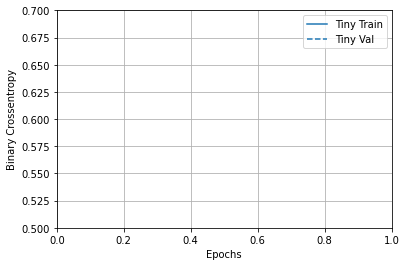

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [20]:
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
#x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["categorical_accuracy"])

In [21]:
model.fit(train,
          validation_data=val,
          epochs=4)
model.save('MOA_model_1')

Epoch 1/4
34/34 [==============================] - 41s 1s/step - loss: 0.0527 - categorical_accuracy: 0.3947 - val_loss: 0.0526 - val_categorical_accuracy: 0.3922
Epoch 2/4
34/34 [==============================] - 38s 1s/step - loss: 0.0528 - categorical_accuracy: 0.3947 - val_loss: 0.0525 - val_categorical_accuracy: 0.3922
Epoch 3/4
34/34 [==============================] - 36s 1s/step - loss: 0.0528 - categorical_accuracy: 0.3947 - val_loss: 0.0526 - val_categorical_accuracy: 0.3922
Epoch 4/4
34/34 [==============================] - 38s 1s/step - loss: 0.0528 - categorical_accuracy: 0.3947 - val_loss: 0.0526 - val_categorical_accuracy: 0.3922


KeyboardInterrupt: ignored

In [ ]:
loss, accuracy = model.evaluate(test)
print("Accuracy", accuracy)

In [ ]:

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
#model.save("drive/MyDrive/lish-moa")
